# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов, в котором можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Для оценки качества моделей необходимо применить метрику RMSE, значение которой должно быть меньше 2500 EUR.

Целевой признак
- Price — цена (евро)

Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

## Подготовка данных

Подключим необходимые библиотеки и определим полезные умолчания.

In [91]:
!pip install lightgbm optuna scikit-learn pandas -U

In [10]:
import os
import re
import optuna
import warnings
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

from urllib.error import HTTPError
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet
from optuna.integration import OptunaSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from optuna.distributions import (UniformDistribution, 
                                  LogUniformDistribution, 
                                  IntUniformDistribution)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import train_test_split, cross_val_score

plt.style.use('dark_background');            # Dark theme for plots
plt.rc('grid', color=(.3, .3, .3));          # Pale grid lines
plt.rc('axes', grid=True, axisbelow=True);   # Grid lines behind the plot
pd.set_option('display.max_columns', None);  # Display all dataframe columns
pd.set_option('display.max_rows', 100);      # Display 100 dataframe rows

# Disable warnings
pd.options.mode.chained_assignment = None    
warnings.simplefilter('ignore', pd.errors.PerformanceWarning) 

Зафиксируем random state.

In [11]:
# Custom random state
RS = 22221111

Загрузим датасет и взглянем на него.

In [92]:
path = '/datasets/autos.csv'
if not os.path.exists(path): 
    path = 'https://code.s3.yandex.net' + path
try:
    df = pd.read_csv(path)
    print('Success: ' + path)
except HTTPError as err:
    print(f'{err} {path}')

Success: https://code.s3.yandex.net/datasets/autos.csv


In [13]:
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


Сразу приведем названия признаков к каноничному «змеиному регистру» и продолжим знакомство с датасетом.

In [95]:
df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower() for col in df.columns]

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [16]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [17]:
pd.concat([
    df.isna().sum().rename('na_num'), 
    df.isna().mean().rename('na_rate')
], axis=1).query('na_num > 0')

,na_num,na_rate
vehicle_type,37490,0.105794
gearbox,19833,0.055967
model,19705,0.055606
fuel_type,32895,0.092827
not_repaired,71154,0.200791


Три признака-даты сохранены как текст, еще один – в виде двух чисел: года и месяца. Явные пропуски есть только в категориальных признаках: во всех, кроме марки автомобиля. 

Столбец с количеством фото нулевой – удалим его.

In [18]:
df = df.drop(columns='number_of_pictures')

Удалим полные дубли.

In [19]:
print(df.duplicated().sum())
df = df.drop_duplicates()

4


Напишем универсальную функцию для рисования гистограммы по выбранному столбцу датасета.

In [20]:
def my_hist(by, bins=20, title=None, numeric=None, year=False, xticks_rot=0,
            sort_index=False, head=None, **kwargs):
    '''Plots histogram of column “by” in dataset “df”'''
    
    if not title: 
        title = by.replace('_', ' ').title() + ' Histogram'
    if year:
        col = df[by].dt.year
    else:
        col = df[by]
    if numeric is None: numeric = pd.api.types.is_numeric_dtype(col)
    kwargs = dict(kwargs, alpha=.7, title=title)
    
    if numeric: 
        col.plot.hist(bins=bins, edgecolor='k', **kwargs); 
    else: 
        vc = col.value_counts(dropna=False)
        if sort_index: vc = vc.sort_index()
        if head: vc = vc.head(head)
        vc.plot(kind='bar', grid=False, **kwargs);
            
    plt.xticks(rotation=xticks_rot);
    plt.xlabel('');
    plt.ylabel('Number of Objects');
    plt.show();
    
    if numeric: print(f'{col.min()} ≤ {by} ≤ {col.max()}');

### Признаки-даты

Приведем столбцы с датами к типу `datetime`.

In [93]:
date_cols = ['date_crawled', 'date_created', 'last_seen']

In [96]:
df[date_cols] = df[date_cols].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S')

In [99]:
df[date_cols].describe(datetime_is_numeric=True)

,date_crawled,date_created,last_seen
count,354369,354369,354369
mean,2016-03-21 12:58:10.450648320,2016-03-20 19:12:07.753274112,2016-03-29 23:51:00.667456768
min,2016-03-05 14:06:22,2014-03-10 00:00:00,2016-03-05 14:15:08
25%,2016-03-13 11:52:33,2016-03-13 00:00:00,2016-03-23 02:50:03
50%,2016-03-21 17:50:55,2016-03-21 00:00:00,2016-04-03 15:15:51
75%,2016-03-29 14:37:20,2016-03-29 00:00:00,2016-04-06 10:15:19
max,2016-04-07 14:36:58,2016-04-07 00:00:00,2016-04-07 14:58:51


Объявления создавались с 2014 по 2016 годы, а скачивались в марте–апреле 2016.

Если рассматривать коллекционные авто как выбросы, то можно считать, что стоимость автомобиля зависит не от года его выпуска, а от его возраста в годах, то есть разницы между текущим годом и годом регистрации (*здесь мы допускаем, что возраст достаточно определить с точностью до года (месяцами пренебрегаем) и что автомобиль не эксплуатировался с момента выпуска до регистрации*). Это значит, что четыре признака-даты в датасете можно заменить одним – возрастом автомобиля в годах, который будет разницей между годом создания объявления и годом регистрации. 

Вспомним, что наша задача – разработать модель, максимально точно определяющую рыночную стоимость автомобиля по данным о нем, которые введет пользователь. Для обучения модели необходимо использовать данные, очищенные от выбросов, потому что они ухудшат качество предсказаний. Поэтому перед расчетом возраста очистим от выбросов признак `registration_year`.

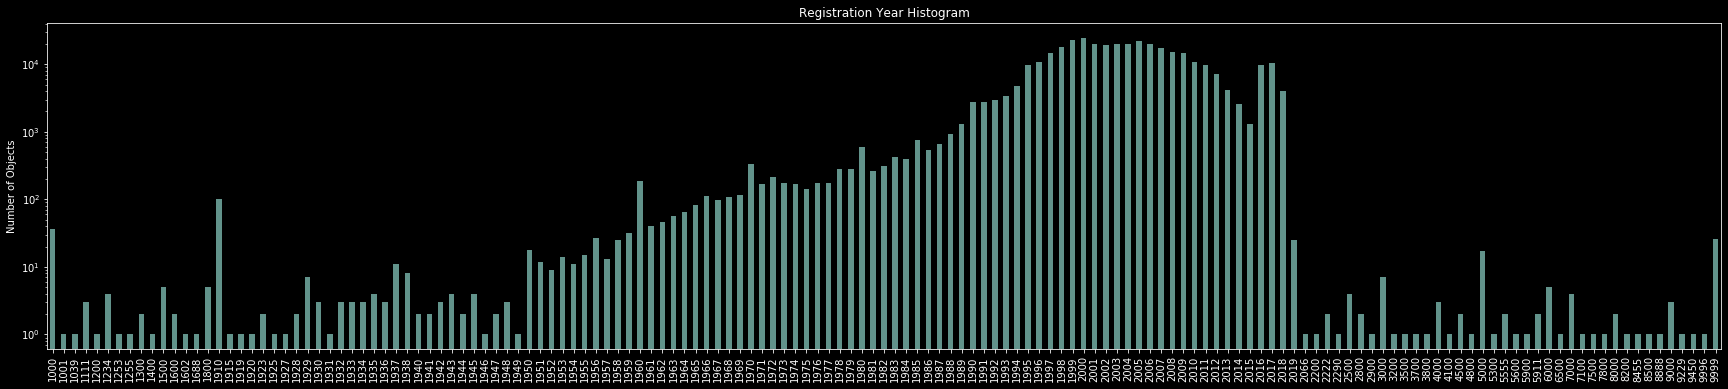

In [24]:
my_hist('registration_year', numeric=False, figsize=(30, 6), logy=True,
       xticks_rot=90, sort_index=True)

Глядя на гистограмму, выберем такие границы выбросов: 1950 и 2019 годы. Объявления с годом регистрации авто с 2017 по 2019 будем считать либо преувеличением автором новизны продаваемого автомобиля, либо предзаказом.

In [25]:
len_before = len(df)
df = df.query('1950 <= registration_year <= 2019')
len_after = len(df)
print(len_before-len_after, 1 - len_after/len_before)

351 0.0009905041412103799


Выбросов оказалось всего 0,1%. Взглянем на распределение объявлений по годам создания и рассчитаем возраст авто.

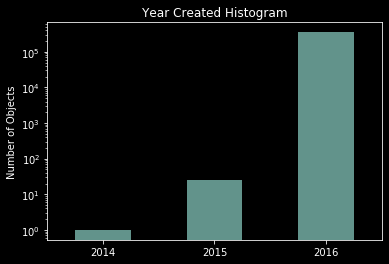

In [26]:
my_hist('date_created', title='Year Created Histogram', year=True, logy=True,
        numeric=False, sort_index=True)

In [27]:
df['years_old'] = (df['date_created'].dt.year 
                   - df['registration_year']).clip(0).astype('uint8')

Удалим ненужные уже признаки-даты.

In [28]:
df = df.drop(columns=date_cols+['registration_year', 'registration_month'])

In [29]:
df

,price,vehicle_type,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,postal_code,years_old
0,480,NaN,manual,0,golf,150000,petrol,volkswagen,NaN,70435,23
1,18300,coupe,manual,190,NaN,125000,gasoline,audi,yes,66954,5
2,9800,suv,auto,163,grand,125000,gasoline,jeep,NaN,90480,12
3,1500,small,manual,75,golf,150000,petrol,volkswagen,no,91074,15
4,3600,small,manual,69,fabia,90000,gasoline,skoda,no,60437,8
...,...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,manual,0,colt,150000,petrol,mitsubishi,yes,2694,11
354365,2200,NaN,NaN,0,NaN,20000,NaN,sonstige_autos,NaN,39576,11
354366,1199,convertible,auto,101,fortwo,125000,petrol,smart,no,26135,16
354367,9200,bus,manual,102,transporter,150000,gasoline,volkswagen,no,87439,20


### Количественные признаки

Посмотрим на гистограмму цен.

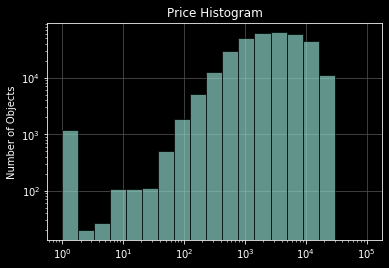

0 ≤ price ≤ 20000


In [30]:
my_hist('price', bins=np.logspace(0, 5, 20), loglog=True)

Проверим, сколько объявлений с нулевой ценой.

In [31]:
df['price'].value_counts(normalize=True).sort_index().head()

0    0.030185
1    0.003299
2    0.000034
3    0.000023
4    0.000003
Name: price, dtype: float64

Таких объявлений немало – 3%. Нулевая цена – это неявный пропуск. Пропуски в целевом признаке делают объекты бесполезными для обучения – удалим такие объявления.

In [32]:
len_before = len(df)
df = df.query('price > 0')
len_after = len(df)
print(len_before-len_after, 1 - len_after/len_before)

10686 0.030185246911139108


Исследуем гистограмму мощности двигателя.

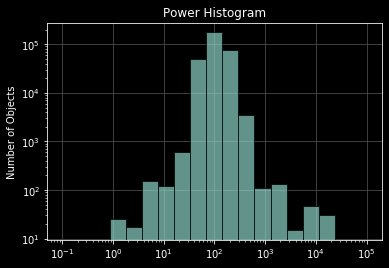

0 ≤ power ≤ 20000


In [33]:
my_hist('power', bins=np.logspace(-1, 5, 20), loglog=True)

In [34]:
df['power'].value_counts(normalize=True).sort_index().head()

0    0.105380
1    0.000076
2    0.000026
3    0.000023
4    0.000087
Name: power, dtype: float64

Объявлений с нулевой мощностью еще больше, чем с нулевой ценой – 11%. Так же, как и в случае с ценой, это неявные пропуски. LightGBM умеет работать с пропусками в признаках, но другие модели, которые мы будем использовать для сравнения, – нет. Однако сама по себе мощность не должна сильно влиять на цену, потому что вполне определяется моделью и другими фичами авто. Т.е. этот признак, скорее всего, не очень значим. А потому позволим себе проще отнестись к пропускам в нем: заменим нули на `NaN`, чтобы довериться алгоритму LightGBM, а для других моделей потом сделаем обратную замену в пайплайне.

In [35]:
df['power'] = df['power'].replace(0, np.nan)

Посмотрим на гистограмму пробега.

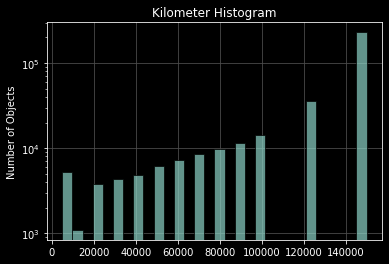

5000 ≤ kilometer ≤ 150000


In [36]:
my_hist('kilometer', bins=30, logy=True)

In [37]:
df['kilometer'].value_counts().sort_index()

5000        5224
10000       1098
20000       3834
30000       4327
40000       4854
50000       6148
60000       7365
70000       8491
80000       9899
90000      11390
100000     14440
125000     35759
150000    230499
Name: kilometer, dtype: int64

Настораживает доминирование пробега в 150 000 км и небольшое разнообразие значений. Возможно, в объявлениях пробег был проставлен диапазонами.

Наконец, взглянем на разброс и частотность почтовых индексов.

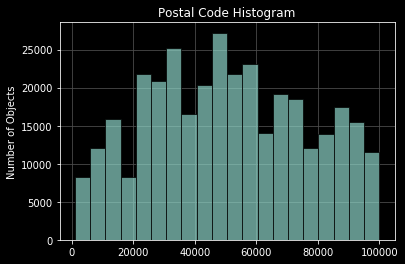

1067 ≤ postal_code ≤ 99998


In [38]:
my_hist('postal_code')

Вроде ничего подозрительного.

### Категориальные признаки

Посмотрим на гистограммы категориальных признаков.

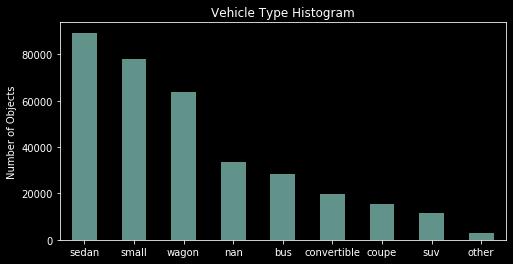

In [39]:
my_hist('vehicle_type', figsize=(8, 4))

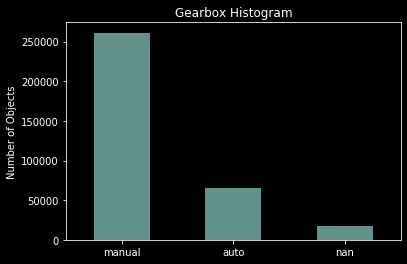

In [40]:
my_hist('gearbox')

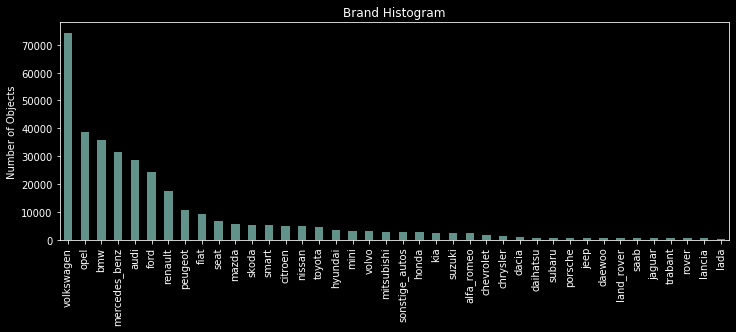

In [41]:
my_hist('brand', figsize=(12, 4), xticks_rot=90)

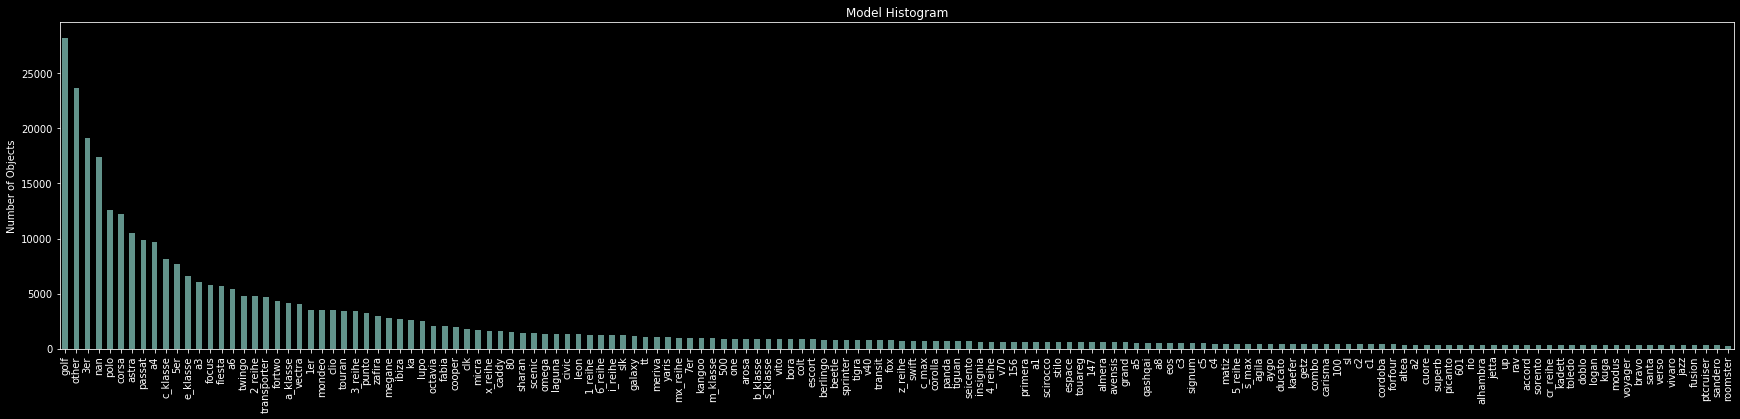

In [42]:
my_hist('model', figsize=(30, 6), xticks_rot=90, head=150)

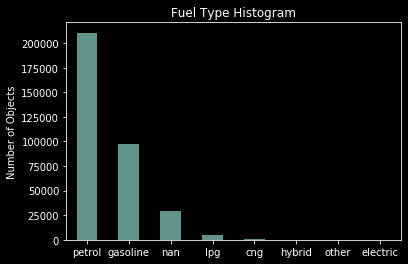

In [43]:
my_hist('fuel_type')

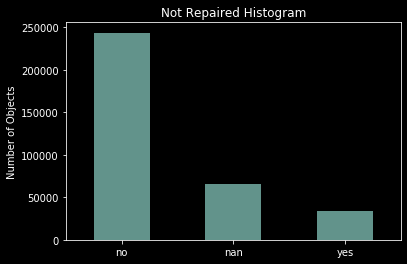

In [44]:
my_hist('not_repaired')

Явные пропуски есть везде, кроме признака `brand` – оставим их (LightGBM разберется с ними сам, а для других моделей используем прямое кодирование с игнорированием пропусков). Чтобы LightGBM автоматически распознал категориальные признаки, приведем их к категориальному типу.

In [45]:
cat_cols = list(df.select_dtypes(object).columns)

In [46]:
df[cat_cols] = df[cat_cols].astype('category')

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343328 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   price         343328 non-null  int64   
 1   vehicle_type  309757 non-null  category
 2   gearbox       326142 non-null  category
 3   power         307148 non-null  float64 
 4   model         325915 non-null  category
 5   kilometer     343328 non-null  int64   
 6   fuel_type     314024 non-null  category
 7   brand         343328 non-null  category
 8   not_repaired  277654 non-null  category
 9   postal_code   343328 non-null  int64   
 10  years_old     343328 non-null  uint8   
dtypes: category(6), float64(1), int64(3), uint8(1)
memory usage: 15.7 MB


## Обучение моделей

### Train-Test Split

Отделим целевой признак от остальных и разобъем датасет на обучающую и тестовую выборки.

In [48]:
X = df.drop(columns='price')
y = df['price']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, 
                                                    random_state=RS)
print(X_train.shape, '\t', X_test.shape)
print(y_train.shape, '\t', y_test.shape)

(257496, 10) 	 (85832, 10)
(257496,) 	 (85832,)


### Dummy

Сократим написание целевой метрики, обернув ее в пользовательскую функцию.

In [50]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

В качестве бейзлайна-ориентира будем использовать метрики *дамми*-моделей на обучающей выборке.

In [51]:
dummy_mean = DummyRegressor(strategy='mean')
dummy_median = DummyRegressor(strategy='median')

In [59]:
print(rmse(y_train, dummy_mean.fit(X_train, y_train).predict(X_train)))
print(rmse(y_train, dummy_median.fit(X_train, y_train).predict(X_train)))

4517.496955718765
4812.741692349102


In [60]:
-cross_val_score(
    dummy_mean,
    X_train, y_train,
    scoring='neg_root_mean_squared_error',
    cv=3,
).mean()

4517.500042432804

In [61]:
-cross_val_score(
    dummy_median,
    X_train, y_train,
    scoring='neg_root_mean_squared_error',
    cv=3,
).mean()

4813.766295405169

### LightGBM

С помощью `optuna` подберем число деревьев и скорость обучения модели LightGBM.

In [62]:
lgb_space = dict(
    n_estimators=IntUniformDistribution(2000, 4000),
    learning_rate=LogUniformDistribution(1e-2, 1e-1),
)

In [63]:
%%time
lgb_model = OptunaSearchCV(
    estimator=lgb.LGBMRegressor(seed=RS),
    param_distributions=lgb_space,
    cv=3,
    n_trials=10,
    scoring='neg_root_mean_squared_error',
    random_state=RS,
).fit(X_train, y_train)

C:\Users\Victor\anaconda3\envs\praktikum_env_win_new\lib\site-packages\ipykernel_launcher.py:7: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.

[I 2022-06-23 01:49:45,619] A new study created in memory with name: no-name-2e3d9fa6-f7b0-434e-a5f1-6b3889067348
[I 2022-06-23 01:50:33,992] Trial 0 finished with value: -1585.8302478225924 and parameters: {'n_estimators': 2781, 'learning_rate': 0.09302309730224215}. Best is trial 0 with value: -1585.8302478225924.
[I 2022-06-23 01:51:55,078] Trial 1 finished with value: -1630.8442840374728 and parameters: {'n_estimators': 2313, 'learning_rate': 0.015872412476431435}. Best is trial 0 with value: -1585.8302478225924.
[I 2022-06-23 01:53:26,506] Trial 2 finished with value: -1583.0398757161302 and parameters: {'n_estimators': 3659, 'learning_rate': 0.08523543521512343}. Best is trial 2 with value: -1583.0398757161302.
[I 2022-06-23 01:55:14,970] Trial 3 finished with value: 

Wall time: 15min 43s


In [64]:
lgb_model.best_estimator_

LGBMRegressor(learning_rate=0.08654570647968698, n_estimators=3876,
              seed=22221111)

In [69]:
-lgb_model.best_score_

1582.2826694990088

Средниее значение RMSE на кросс-валидации обучающей выборки втрое ниже константных дамми-предсказаний – хороший результат.

Посмотрим на значимость признаков по версии LightGBM.

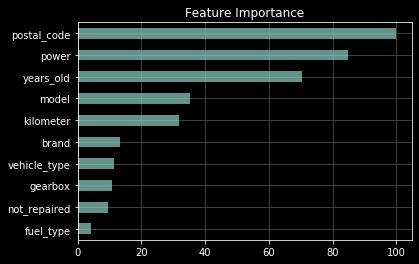

In [70]:
impo = lgb_model.best_estimator_.feature_importances_
(
    (100*pd.Series(impo, X.columns) / impo.max())
    .sort_values().plot(kind='barh', alpha=.7, title='Feature Importance')
);

Самыми значимыми на удивление оказались фичи `postal_code` и `power`.

Замерим время обучения модели и время расчета предсказаний на обучающей выборке.

In [66]:
%time lgb_model.best_estimator_.fit(X_train, y_train)
%time _ = lgb_model.best_estimator_.predict(X_train);

Wall time: 19.7 s
Wall time: 21.7 s


### ElasticNet

В качестве первой альтернативы градиентному бустингу рассмотрим линейную регрессионную модель ElasticNet, в которой используется микс L1- и L2-регуляризаций. Эта модель не переваривает пропуски и категориальные фичи и чувствительна к масштабу количественных фич. Поэтому обернем ее в пайплайн с предобработкой из импьютера и скейлера для количественных фич (помним, что пропуски есть только в мощности) и прямого кодирования для категориальных.

In [71]:
num_tformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

cat_tformer = OneHotEncoder(handle_unknown='ignore')

preproc = ColumnTransformer([
        ('num', num_tformer, make_column_selector(dtype_include='number')),
        ('cat', cat_tformer, make_column_selector(dtype_include='category'))
])

In [72]:
enet_pipe = Pipeline([
    ('preproc', preproc), 
    ('enet', ElasticNet(max_iter=10000, random_state=RS)),
])

С помощью `optuna` подберем коэффициенты регуляризации `alpha` и `l1_ratio`.

In [73]:
enet_space = dict(
    enet__alpha=UniformDistribution(.01, .1),
    enet__l1_ratio=UniformDistribution(.9, 1),
)

In [74]:
%%time
enet_model = OptunaSearchCV(
    estimator=enet_pipe,
    param_distributions=enet_space,
    cv=3,
    n_trials=10,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error',
    random_state=RS,
).fit(X_train, y_train)

C:\Users\Victor\anaconda3\envs\praktikum_env_win_new\lib\site-packages\ipykernel_launcher.py:8: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.

[I 2022-06-23 02:23:36,909] A new study created in memory with name: no-name-3237c09c-acf3-405f-9fba-c51ab6ca8608
C:\Users\Victor\anaconda3\envs\praktikum_env_win_new\lib\site-packages\optuna\study\study.py:397: FutureWarning:

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.

[I 2022-06-23 02:32:08,240] Trial 6 finished with value: -2913.121791437153 and parameters: {'enet__alpha': 0.09747867757912626, 'enet__l1_ratio': 0.9685595736948618}. Best is trial 6 with value: -2913.121791437153.
[I 2022-06-23 02:35:27,898] Trial 7 finished with value: -2897.7324247905835 and parameters: {'enet__alpha': 0.030952665314225025, 'enet__l1_ratio': 0.9259249166114325}. Best is trial 7 with v

Wall time: 25min 23s


In [75]:
enet_model.best_estimator_.get_params()['enet']

ElasticNet(alpha=0.021846401245352122, l1_ratio=0.9715546495787957,
           max_iter=10000, random_state=22221111)

In [77]:
-enet_model.best_score_

2850.399314512208

RMSE модели в полтора раза ниже, чем у константных дамми-предсказаний, но барьер в 2500 EUR модель не преодолевает.

Замерим время обучения модели и время расчета предсказаний на обучающей выборке.

In [80]:
%time enet_model.best_estimator_.fit(X_train, y_train)
%time _ = enet_model.best_estimator_.predict(X_train);

Wall time: 1min 57s
Wall time: 667 ms


Время обучения выбранной модели ElasticNet в несколько раз больше, чем модели LightGBM. Зато время предсказания – в несколько десятков раз меньше. 

### DecisionTreeRegressor

В качестве второй альтернативы градиентному бустингу рассмотрим модель дерева решений DecisionTreeRegressor. Эта модель тоже не переваривает пропуски и категориальные фичи, но она не чувствительна к масштабу количественных фич. Поэтому обернем ее в тот же пайплайн, из которого прежде уберем скейлер.

In [81]:
num_tformer.steps.pop();  # Remove StandardScaler from the pipe
dt_pipe = Pipeline([
    ('preproc', preproc), 
    ('dt', DecisionTreeRegressor(random_state=RS))
])

С помощью `optuna` подберем максимальную глубину дерева и минимальное число объектов в листьях.

In [82]:
dt_space = dict(
    dt__max_depth=IntUniformDistribution(20, 30),
    dt__min_samples_leaf=IntUniformDistribution(10, 20),
)

In [83]:
%%time
dt_model = OptunaSearchCV(
    estimator=dt_pipe,
    param_distributions=dt_space,
    cv=3,
    n_trials=10,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error',
    random_state=RS,
).fit(X_train, y_train)

C:\Users\Victor\anaconda3\envs\praktikum_env_win_new\lib\site-packages\ipykernel_launcher.py:8: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.

[I 2022-06-23 03:04:43,510] A new study created in memory with name: no-name-dc45ed40-e81a-4db6-b8db-00e887607d7f
C:\Users\Victor\anaconda3\envs\praktikum_env_win_new\lib\site-packages\optuna\study\study.py:397: FutureWarning:

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.

[I 2022-06-23 03:06:50,378] Trial 2 finished with value: -1904.2749635303614 and parameters: {'dt__max_depth': 22, 'dt__min_samples_leaf': 17}. Best is trial 2 with value: -1904.2749635303614.
[I 2022-06-23 03:06:52,190] Trial 3 finished with value: -1893.9988445472752 and parameters: {'dt__max_depth': 20, 'dt__min_samples_leaf': 13}. Best is trial 3 with value: -1893.9988445472752.
[I 2022-06-23 03:06:54

Wall time: 3min 29s


In [84]:
dt_model.best_estimator_.get_params()['dt']

DecisionTreeRegressor(max_depth=20, min_samples_leaf=13, random_state=22221111)

In [86]:
-dt_model.best_score_

1893.9988445472752

Эта простая модель показывет на удивление низкое значение RMSE, не сильно уступающее модели LightGBM: метрика в два с половиной раза ниже, чем у константных дамми-предсказаний.

Замерим время обучения модели, время расчета предсказаний и рассчитаем RMSE на обучающей выборке.

In [87]:
%time dt_model.best_estimator_.fit(X_train, y_train)
%time _ = dt_model.best_estimator_.predict(X_train);

Wall time: 23.1 s
Wall time: 718 ms


Время обучения выбранной модели DecisionTreeRegressor сравнимо с моделью LightGBM, а время предсказания – в несколько десятков раз меньше. 

## Тестирование лучшей модели

По совокупности трех критериев: RMSE (основной критерий), времени обучения и времени предсказания – побеждает модель LightGBM. Рассчитаем ее RMSE на тестовой выборке. Для сравнения сделаем то же самое для дамми-моделей.

In [88]:
rmse(y_test, lgb_model.best_estimator_.predict(X_test))

1545.6573165023929

In [89]:
print(rmse(y_test, dummy_mean.predict(X_test)))
print(rmse(y_test, dummy_median.predict(X_test)))

4504.201148351215
4795.657775490989


Результат остался хорошим: в три раза ниже, чем у константных дамми-предсказаний.

Обучим модель на всем датасете и посчитаем RMSE на нем же.

In [90]:
%time lgb_model.best_estimator_.fit(X, y)
rmse(y, lgb_model.best_estimator_.predict(X))

Wall time: 28.3 s


1199.190875156692

В продакшн! :)